In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# Number of data points
N = 100

# X ~ U[0, 2π]
X = np.random.uniform(0, 2*np.pi, size=N)

# 2) epsilon(noise) ~ N(0, 0.1^2)
epsilon = np.random.normal(loc=0.0, scale=0.1, size=N)
y = np.sin(X) + epsilon


X = X.reshape(-1, 1)

## Running the Regression

In [6]:
def polynomial_features(X, degree):
    N = X.shape[0]
    features = [np.ones(N)]
    for d in range(1, degree+1):
        features.append(X[:, 0]**d)

    return np.column_stack(features)

def fit_polynomial(X, y, degree):
    """
    Fit a polynomial of given 'degree' to data (X, y).
    Returns: coefficients of the polynomial.
    """
    XX = polynomial_features(X, degree)

    # Solving OLS. W stores the coefficients. other returned values are not needed
    W, _, _, _ = np.linalg.lstsq(XX, y, rcond=None)
    return W

def predict_polynomial(X_new, W):
    """
    X_new: shape (M, 1)
    W: shape (degree+1,)
    Returns: predictions of shape (M,)
    """
    degree = len(W) - 1
    X_newest = polynomial_features(X_new, degree)
    return X_newest @ W


## Implementing the Methods for Cross-Validation

In [7]:
def create_folds(X, y, n_folds=5):
    """
    Creates and returns the folds
    """
    N = len(y)
    indices = np.arange(N)
    np.random.shuffle(indices)

    fold_size = N // n_folds
    folds = []
    for i in range(n_folds):
        start = i*fold_size
        end = (i+1)*fold_size
        fold_indices = indices[start:end]
        folds.append((X[fold_indices], y[fold_indices]))

    return folds

def cross_val_score_polynomial(X, y, degree, n_folds=5):
    """
    Perform 5-fold cross-validation for a polynomial of degree 'degree'.
    Return the average MSE across folds.
    """
    folds = create_folds(X, y, n_folds)
    mse_list = []

    for i in range(n_folds):
        # Fold i is used as val, rest are train data
        X_val, y_val = folds[i]

        X_train_list = []
        y_train_list = []
        for j in range(n_folds):
            if j != i:
                X_train_list.append(folds[j][0])
                y_train_list.append(folds[j][1])

        X_train_cv = np.vstack(X_train_list)
        y_train_cv = np.hstack(y_train_list)

        # Training the model, then predicting on val set
        W = fit_polynomial(X_train_cv, y_train_cv, degree)
        y_pred_val = predict_polynomial(X_val, W)

        # Compute MSE
        mse_fold = np.mean((y_val - y_pred_val)**2)
        mse_list.append(mse_fold)

    return np.mean(mse_list)


## Performing Cross Validation on the Data

In [8]:
degrees = [0, 1, 2, 3, 4]
cv_errors = []

for d in degrees:
    mse = cross_val_score_polynomial(X, y, d, n_folds=5)
    cv_errors.append(mse)
    print(f"Degree {d}, 5-fold Cross-Validation MSE = {mse:.5f}")

# Finding the degree of the best model
best_degree = degrees[np.argmin(cv_errors)]
print("\nBest degree based on 5-fold Cross-Validation:", best_degree)


Degree 0, 5-fold Cross-Validation MSE = 0.52739
Degree 1, 5-fold Cross-Validation MSE = 0.20710
Degree 2, 5-fold Cross-Validation MSE = 0.21063
Degree 3, 5-fold Cross-Validation MSE = 0.01318
Degree 4, 5-fold Cross-Validation MSE = 0.01400

Best degree based on 5-fold Cross-Validation: 3


## Plotting the True Function, Noisy Data and Prediction of the Model

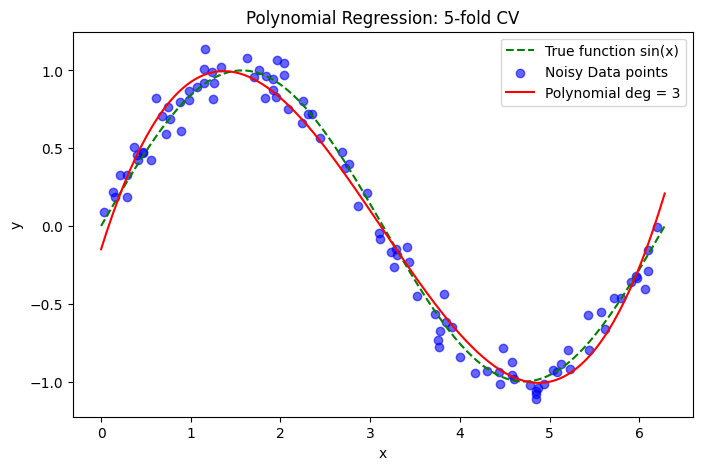

In [10]:
W_best = fit_polynomial(X, y, best_degree)

x_grid = np.linspace(0, 2*np.pi, 200).reshape(-1, 1)
y_true = np.sin(x_grid)                                   # True function
y_model = predict_polynomial(x_grid, W_best)

plt.figure(figsize=(8, 5))

# Plotting
plt.plot(x_grid, y_true, 'g--', label='True function sin(x)')               # true func
plt.scatter(X, y, color='blue', alpha=0.6, label='Noisy Data points')           # noisy data
plt.plot(x_grid, y_model, 'r-', label=f'Polynomial deg = {best_degree}')      # regression model

plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression: 5-fold CV')
plt.legend()
plt.show()
